In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import cv2
from scipy import signal

### 3D Camera Geometry

In class we covered material for single and multi-camera systems. This notebook will help ground some of these geometric concepts.

First, we'll define some of the components we'll need for camera geometry

In [2]:
def rotate(t) :
    return [[np.cos(t),-np.sin(t),0],[np.sin(t),np.cos(t),0],[0,0,1]]
def rotate2D(t) :
    return [[np.cos(t),-np.sin(t)],[np.sin(t),np.cos(t)]]
def trans(x,y,z) :
    return np.array([[x,y,z]]).T
def htrans(R,t) :
#    print([R,t].shape)
    return np.concatenate((np.concatenate((R,t),axis=1),np.array([[0,0,0,1]])))
        

Now, we'll define some components for camera internal geometry

In [3]:
def Kmatrix(sx,sy,ox,oy) :
    return np.array([[sx,0,ox],[0,sy,oy],[0,0,1]])
def Mmatrix(K) :
    return np.concatenate((K, np.array([[0,0,0]]).T),axis=1)

Now, define camera projection in terms of htrans and Mmatrix

In [4]:
def Pmatrix(H,M) :
    return M*H

In [5]:


pts = np.concatenate((np.random.random([2,10]),np.ones([1,10])),axis=0)

In [6]:
pts.T

array([[0.25254088, 0.99546515, 1.        ],
       [0.99400395, 0.74785414, 1.        ],
       [0.73568644, 0.3344954 , 1.        ],
       [0.86773162, 0.6219642 , 1.        ],
       [0.76630658, 0.65563089, 1.        ],
       [0.2009062 , 0.13386832, 1.        ],
       [0.28492977, 0.18448435, 1.        ],
       [0.52070306, 0.57522347, 1.        ],
       [0.0268827 , 0.09195257, 1.        ],
       [0.84485643, 0.71784781, 1.        ]])

Just setting up a few helper functions

In [7]:
def scale(sx, sy) :
    return [[sx,0,0],[0,sy,0],[0,0,1]]

In [8]:
def shear(sx, sy) :
    return [[1,sx,0],[sy,1,0],[0,0,1]]


In [9]:
def translate(tx, ty) :
    return [[1,0,tx],[0,1,ty],[0,0,1]]

In [10]:
H = np.matmul(translate(3,4),rotate(np.pi/4))
H

array([[ 0.70710678, -0.70710678,  3.        ],
       [ 0.70710678,  0.70710678,  4.        ],
       [ 0.        ,  0.        ,  1.        ]])

In [11]:
opts = np.matmul(H,pts)

Now let's set up H recovery

In [12]:
def arow(x,xp):
    return [[x[0],x[1],1,0,0,0,-xp[0]*x[0],-x[1]*xp[0],-xp[0]],
            [0,0,0,x[0],x[1],1,-xp[1]*x[0],-x[1]*xp[1],-xp[1]]]

In [13]:
A = np.concatenate((arow(pts.T[0],opts.T[0]),
                    arow(pts.T[1],opts.T[1]),
                    arow(pts.T[2],opts.T[2]),
                    arow(pts.T[3],opts.T[3]),
                   ))
A

array([[ 0.25254088,  0.99546515,  1.        ,  0.        ,  0.        ,
         0.        , -0.62495615, -2.46345093, -2.47467321],
       [ 0.        ,  0.        ,  0.        ,  0.25254088,  0.99546515,
         1.        , -1.23302415, -4.86033222, -4.88247352],
       [ 0.99400395,  0.74785414,  1.        ,  0.        ,  0.        ,
         0.        , -3.15502241, -2.37372957, -3.1740542 ],
       [ 0.        ,  0.        ,  0.        ,  0.99400395,  0.74785414,
         1.        , -5.20031025, -3.9125333 , -5.23167967],
       [ 0.73568644,  0.3344954 ,  1.        ,  0.        ,  0.        ,
         0.        , -2.41576247, -1.09837749, -3.28368491],
       [ 0.        ,  0.        ,  0.        ,  0.73568644,  0.3344954 ,
         1.        , -3.49946386, -1.59110525, -4.75673284],
       [ 0.86773162,  0.6219642 ,  1.        ,  0.        ,  0.        ,
         0.        , -2.75399256, -1.97397991, -3.17378381],
       [ 0.        ,  0.        ,  0.        ,  0.86773162,  0

In [14]:
[u,d,v] = la.svd(A,True,True)

In [15]:
d

array([1.67703315e+01, 3.64882745e+00, 2.80819983e+00, 1.49334913e+00,
       6.54405759e-01, 2.52797374e-01, 6.32424234e-03, 4.04873796e-03])

In [16]:
v[8]

array([ 1.33630621e-01, -1.33630621e-01,  5.66946710e-01,  1.33630621e-01,
        1.33630621e-01,  7.55928946e-01, -2.09702399e-15,  2.57711033e-15,
        1.88982237e-01])

In [17]:
v[8]/v[8,8]

array([ 7.07106781e-01, -7.07106781e-01,  3.00000000e+00,  7.07106781e-01,
        7.07106781e-01,  4.00000000e+00, -1.10964079e-14,  1.36367861e-14,
        1.00000000e+00])

In [18]:
np.reshape(v[8]/v[8,8],[3,3])

array([[ 7.07106781e-01, -7.07106781e-01,  3.00000000e+00],
       [ 7.07106781e-01,  7.07106781e-01,  4.00000000e+00],
       [-1.10964079e-14,  1.36367861e-14,  1.00000000e+00]])

In [19]:
H

array([[ 0.70710678, -0.70710678,  3.        ],
       [ 0.70710678,  0.70710678,  4.        ],
       [ 0.        ,  0.        ,  1.        ]])

In [20]:
R =rotate2D(0.6)
pts = np.array([[0,1,2,3,4,5,6,7,8], [1,1,1,1,1,1,1,1,1]])
Kold = np.array([[10,4],[0,1]])
Kinv = la.inv(Kold)
Knew = np.array([[10,0],[0,1]])

In [21]:
H1 = Kold*R*Kinv
forward_res = H1@pts
inverse_res = la.inv(H1)@pts
H2 = Knew*R*Kinv
forward_res_new = H2@pts
inverse_res_new = la.inv(H2)@pts
forward_res

array([[0.90342796, 1.72876357, 2.55409919, 3.3794348 , 4.20477042,
        5.03010603, 5.85544165, 6.68077726, 7.50611288],
       [0.82533561, 0.82533561, 0.82533561, 0.82533561, 0.82533561,
        0.82533561, 0.82533561, 0.82533561, 0.82533561]])

In [22]:
forward_res[0]/forward_res[1]

array([1.09461889, 2.09461889, 3.09461889, 4.09461889, 5.09461889,
       6.09461889, 7.09461889, 8.09461889, 9.09461889])

In [23]:
inverse_res_new[0]/inverse_res_new[1]

array([0., 1., 2., 3., 4., 5., 6., 7., 8.])

Playing around a bit with stereo images note that the code uses a simulated image where I know exactly what the answer is

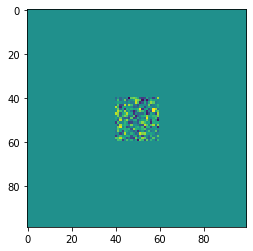

In [24]:
rm1 = np.random.random_sample((99,100))
rm2 = np.copy(rm1)
rm2[40:60,40:60] = rm2[35:55,35:55]
plt.imshow(rm2-rm1)

In [25]:
def finddisp(im1,im2,dmin,dmax) :
    width = 100-dmax-1
    area = im1[:,0:width]
    best = -1*np.ones([99-10,width-10])
    val = np.zeros([99-10,width-10])
    im1sq =  np.sqrt(signal.convolve2d(np.ones([11,11])/121,area,mode='valid'))
    im2sq = np.sqrt(signal.convolve2d(np.ones([11,11])/121,im2,mode='valid'))
    
    for i in range(dmin,dmax) :
        print(i)
        testa = im2[:,i:i+width]
        im2sq = np.sqrt(signal.convolve2d(np.ones([11,11])/121,testa,mode='valid'))
        prod = area*testa
        corr = signal.convolve2d(np.ones([11,11])/121,prod,mode='valid')
#        corr = corr/(im1sq*im2sq)
        val[corr>best]=i
        test = np.stack((corr,best))
        best = np.amax(test,0)
    return val
        
        
        
        

0
1
2
3
4
5
6
7
8
9
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


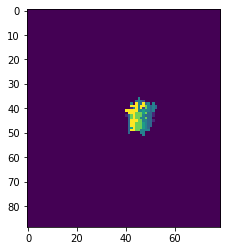

In [26]:
res = finddisp(rm1,rm2,0,10)
print(res)
plt.imshow(res*10)

In [27]:
signal.convolve2d(np.ones([11,11])/121,gimg1,mode='valid')

NameError: name 'gimg1' is not defined

In [ ]:
x = np.ones([3,3])


In [ ]:
z =np.stack((x,x),2)

In [ ]:
x = np.array([1,2, 3])


In [ ]:
z[1]

In [ ]:
x